In [84]:
%pylab inline
import scipy.io as sio
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


#Exploring the data
First I load the data and print it out to see its structure.
Then I plot the output of the channels. From the plot I can see that the 3rd and 37th channel does not provide useful information about the seizure so I cut them out from the 'adat' array.

In [5]:
data=sio.loadmat('Seizure1')
data

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Sep 01 19:13:34 2014',
 '__version__': '1.0',
 'adat': array([[-16,  -4, -81, ...,  82,  54,  41],
        [-17,  -5, -80, ...,  81,  54,  41],
        [-17,  -4, -81, ...,  80,  54,  41],
        ...,
        [ 36,  25,   6, ...,  -6,  17,  12],
        [ 35,  24,   6, ...,  -4,  17,  13],
        [ 34,  24,   6, ...,  -2,  17,  13]], dtype=int16)}

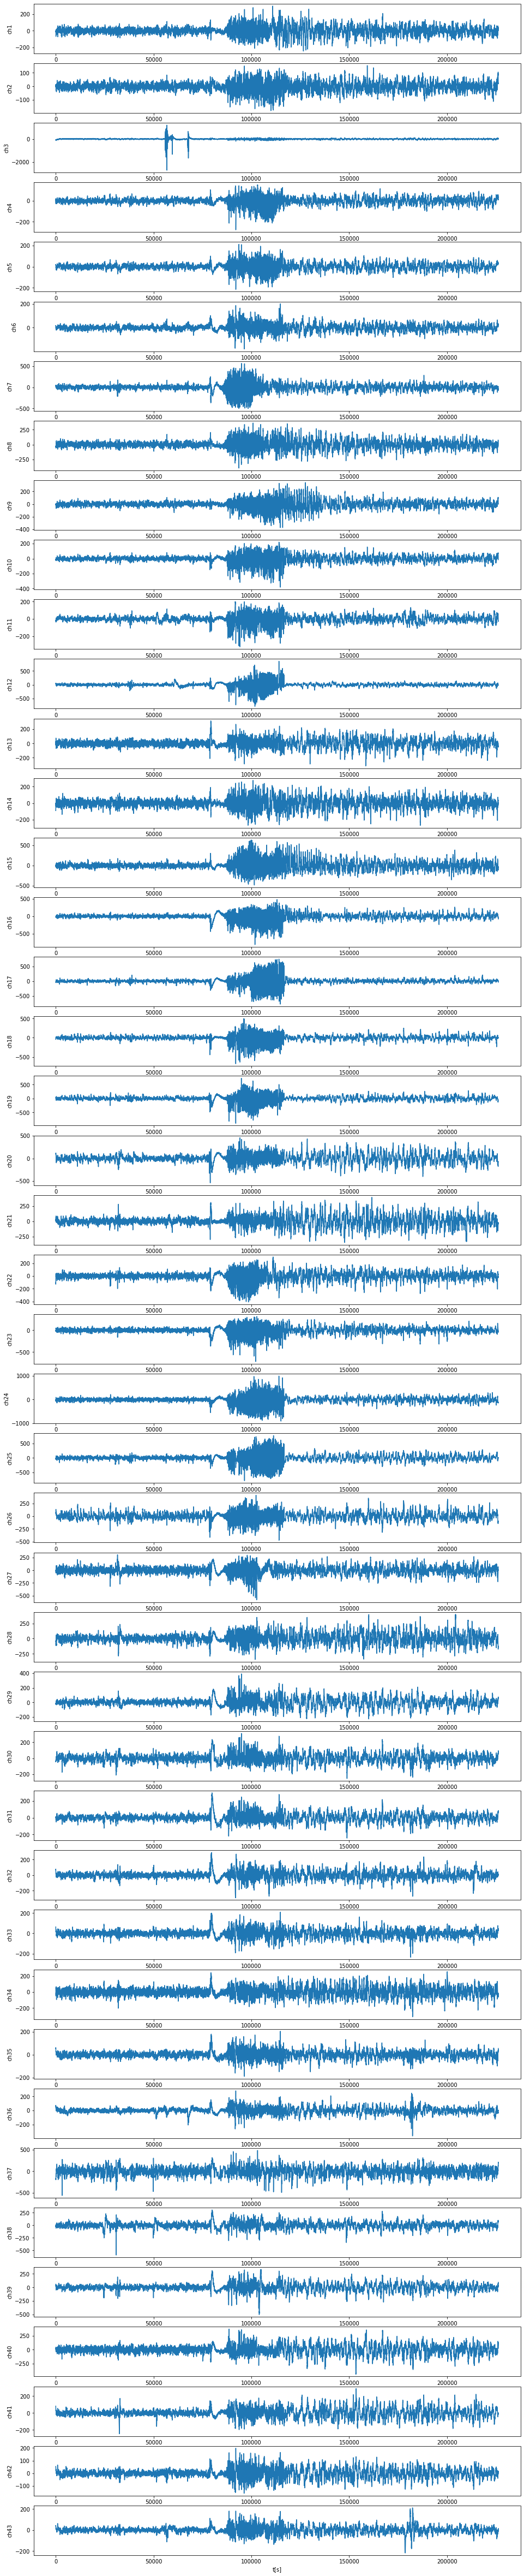

In [6]:
# plotting
figure(figsize=(16,86))

for i in range(43):
    subplot(43,1,i+1)
    plot(data['adat'][:,i])
    ylabel('ch'+str(i+1))
    xlabel('t[s]')

In [7]:
#deleting the 3rd and 37th channel from the dataset
data_cut = np.delete(data['adat'], 36, axis=1)
data_cut = np.delete(data_cut, 2, axis=1)

 I divide the data into three parts. From 0-75s (before the seizure), from 75-120s (seizure), and from 120s to the end (after seizure).

In [8]:
#dividing data
before=data_cut[0:75000,:]
seizure=data_cut[75000:120000,:]
after=data_cut[120000:,:]

# Investigating the corelation between channels

## Coefficient matrix visualisation
I use the built-in corrcoef() function of numpy to calculate the correlation coefficient matrix. I plot the colormap of the three matrices: correlations between the channels before, during, and after seizure. 

In [24]:
before[0].size 

75000

In [51]:
before_corr_matrix=np.corrcoef(before, rowvar=False).round(3) #I round the coefficients because for now it's unneccesarry to know them up to 6 decimals
seizure_corr_matrix=np.corrcoef(seizure, rowvar=False).round(3)
after_corr_matrix=np.corrcoef(after, rowvar=False).round(3)

In [66]:
abs(before_corr_matrix)

array([[1.   , 0.175, 0.11 , ..., 0.19 , 0.102, 0.012],
       [0.175, 1.   , 0.49 , ..., 0.275, 0.161, 0.114],
       [0.11 , 0.49 , 1.   , ..., 0.126, 0.081, 0.058],
       ...,
       [0.19 , 0.275, 0.126, ..., 1.   , 0.677, 0.466],
       [0.102, 0.161, 0.081, ..., 0.677, 1.   , 0.884],
       [0.012, 0.114, 0.058, ..., 0.466, 0.884, 1.   ]])

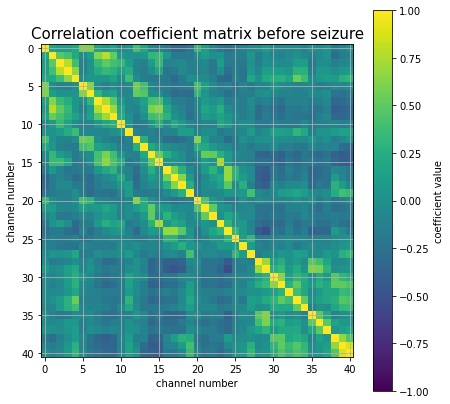

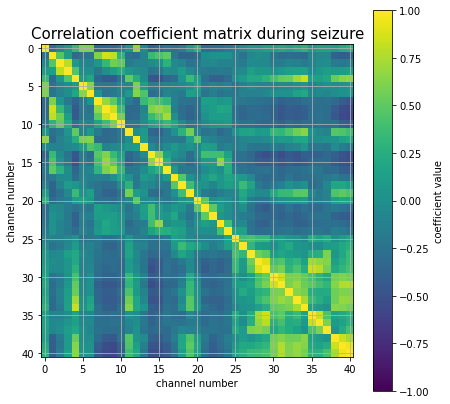

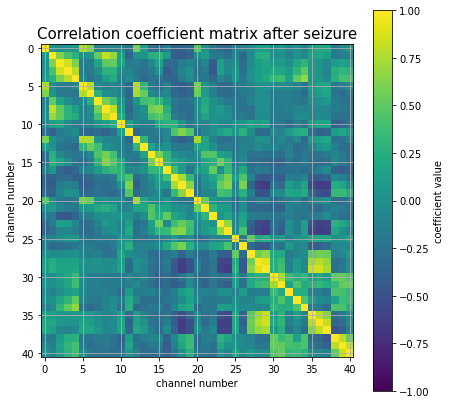

In [65]:
fig, ax = plt.subplots(figsize=(7,7))

im = ax.imshow(before_corr_matrix)
im.set_clim(-1, 1)

ax.grid(True)

cbar = ax.figure.colorbar(im, ax=ax, label="coefficient value")
plt.title('Correlation coefficient matrix before seizure', fontsize=15)
plt.xlabel('channel number')
plt.ylabel('channel number')
plt.show()

############
fig, ax = plt.subplots(figsize=(7,7))

im = ax.imshow(seizure_corr_matrix)
im.set_clim(-1, 1)

ax.grid(True)
cbar = ax.figure.colorbar(im, ax=ax, label="coefficient value")
plt.title('Correlation coefficient matrix during seizure', fontsize=15)
plt.xlabel('channel number')
plt.ylabel('channel number')
plt.show()

############
fig, ax = plt.subplots(figsize=(7,7))

im = ax.imshow(after_corr_matrix)
im.set_clim(-1, 1)

ax.grid(True)
cbar = ax.figure.colorbar(im, ax=ax, label="coefficient value")
plt.title('Correlation coefficient matrix after seizure', fontsize=15)
plt.xlabel('channel number')
plt.ylabel('channel number')
plt.show()

I create the same plot, but with the absolute value of the coefficients. I will use this plot  to choose channels that I will investigat further. Plotting the absolute value of the coefficients will help me to take into consideration the negative correlations as well.
###note:
If the individual matrices would be bigger (there would be more channels) or if there would be more matrices this kind of 'eyeballing' would be very inadequate and time consuming, and I would rather write an algorithm that collects the correlating channels. However, for this three small matrices I choose to pick channels by hand.

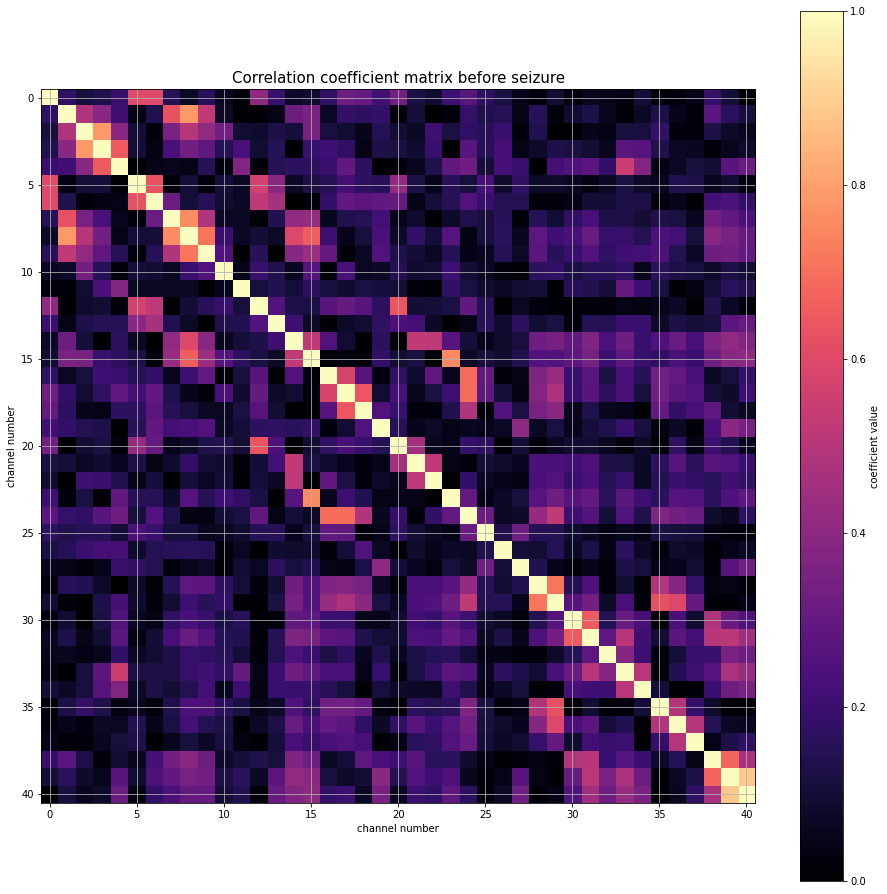

In [68]:
fig, ax = plt.subplots(figsize=(16,16))

im = ax.imshow(abs(before_corr_matrix),cmap='magma')
im.set_clim(0, 1)

ax.grid(True)

cbar = ax.figure.colorbar(im, ax=ax, label="coefficient value")
plt.title('Correlation coefficient matrix before seizure', fontsize=15)
plt.xlabel('channel number')
plt.ylabel('channel number')
plt.show()

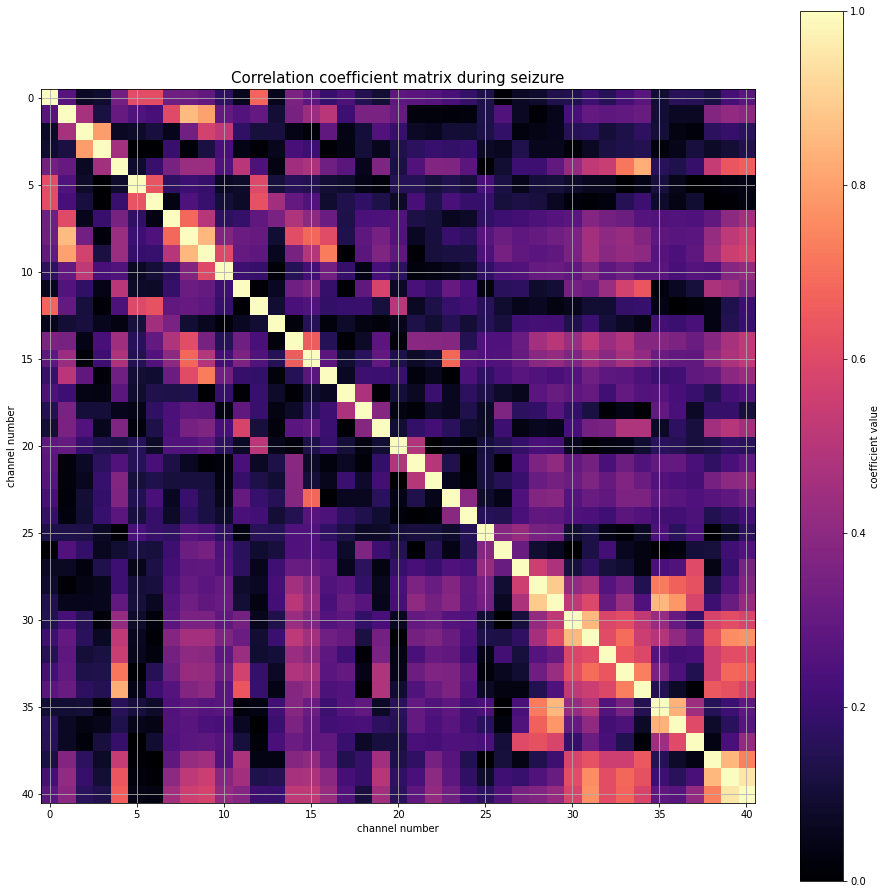

In [69]:
fig, ax = plt.subplots(figsize=(16,16))

im = ax.imshow(abs(seizure_corr_matrix),cmap='magma')
im.set_clim(0, 1)

ax.grid(True)

cbar = ax.figure.colorbar(im, ax=ax, label="coefficient value")
plt.title('Correlation coefficient matrix during seizure', fontsize=15)
plt.xlabel('channel number')
plt.ylabel('channel number')
plt.show()

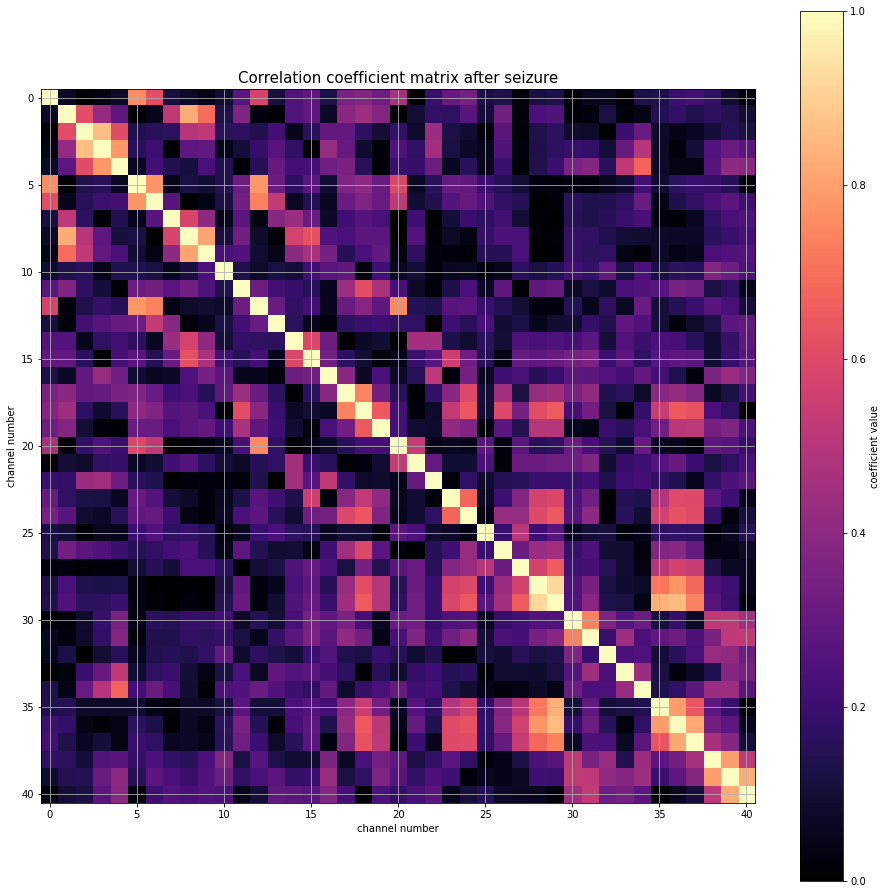

In [70]:
fig, ax = plt.subplots(figsize=(16,16))

im = ax.imshow(abs(after_corr_matrix),cmap='magma')
im.set_clim(0, 1)

ax.grid(True)

cbar = ax.figure.colorbar(im, ax=ax, label="coefficient value")
plt.title('Correlation coefficient matrix after seizure', fontsize=15)
plt.xlabel('channel number')
plt.ylabel('channel number')
plt.show()

From these plots we can clearly see that there is more correlation between the channels during and after the seizure than before. The spatial pattern of correlating channels changes in time, however there is a quite prominent pattern paralell to the autocorrelation coefficient diagonal, that is the correlation between the channels 5-25 and 0-20. This pattern is present in all three periods, although the strength of the correlation differs.

## Plotting the correlation between individual channels

I decided to plot the correlation of some channel pairs and fit a linear regression line on them. First I picked a few channel pairs from the line paralell to the diagonal that I observed on the coefficient matrix colormap, since this is a very prominent pattern in all three periods and it worth further investigatioan.

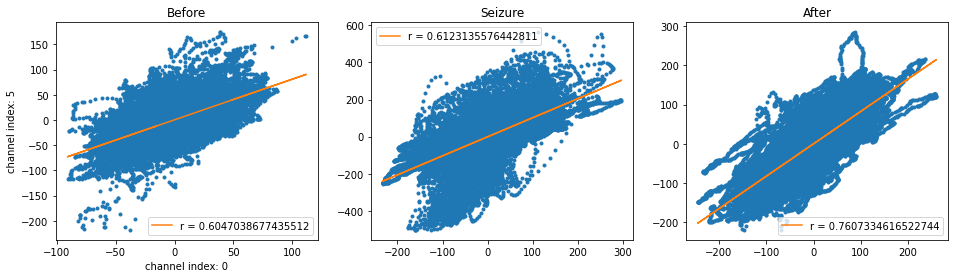

In [96]:
slope1, intercept1, r1,  p, stderr = stats.linregress(before[:,0],before[:,5])
slope2, intercept2, r2,  p, stderr = stats.linregress(seizure[:,0],seizure[:,5])
slope3, intercept3, r3,  p, stderr = stats.linregress(after[:,0],after[:,5])
figure(figsize=(16,4))
subplot(131)
plt.plot(before[:,0],before[:,5], '.')
plot(before[:,0], intercept1 + slope1 * before[:,0], label='r = '+ str(r1))
xlabel('channel index: 0')
ylabel('channel index: 5')
title('Before')
legend()
subplot(132)
plt.plot(seizure[:,0],seizure[:,5], '.')
plot(seizure[:,0], intercept2 + slope2 * seizure[:,0], label='r = '+str(r2))
title('Seizure')
legend()
subplot(133)
plt.plot(after[:,0],after[:,5], '.')
plot(after[:,0], intercept3 + slope3 * after[:,0], label='r = '+str(r3))
title('After')
legend()

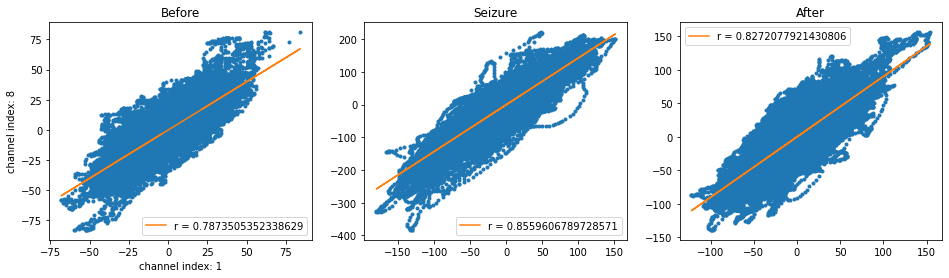

In [97]:
slope1, intercept1, r1,  p, stderr = stats.linregress(before[:,1],before[:,8])
slope2, intercept2, r2,  p, stderr = stats.linregress(seizure[:,1],seizure[:,8])
slope3, intercept3, r3,  p, stderr = stats.linregress(after[:,1],after[:,8])
figure(figsize=(16,4))
subplot(131)
plt.plot(before[:,1],before[:,8], '.')
plot(before[:,1], intercept1 + slope1 * before[:,1], label='r = '+ str(r1))
xlabel('channel index: 1')
ylabel('channel index: 8')
title('Before')
legend()
subplot(132)
plt.plot(seizure[:,1],seizure[:,8], '.')
plot(seizure[:,1], intercept2 + slope2 * seizure[:,1], label='r = '+str(r2))
title('Seizure')
legend()
subplot(133)
plt.plot(after[:,1],after[:,8], '.')
plot(after[:,1], intercept3 + slope3 * after[:,1], label='r = '+str(r3))
title('After')
legend()

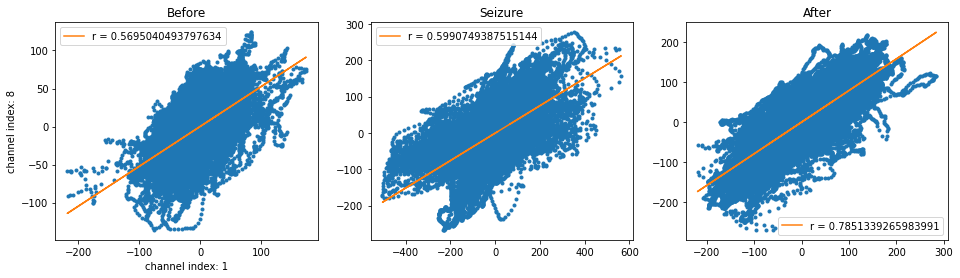

In [98]:
slope1, intercept1, r1,  p, stderr = stats.linregress(before[:,5],before[:,12])
slope2, intercept2, r2,  p, stderr = stats.linregress(seizure[:,5],seizure[:,12])
slope3, intercept3, r3,  p, stderr = stats.linregress(after[:,5],after[:,12])
figure(figsize=(16,4))
subplot(131)
plt.plot(before[:,5],before[:,12], '.')
plot(before[:,5], intercept1 + slope1 * before[:,5], label='r = '+ str(r1))
xlabel('channel index: 5')
ylabel('channel index: 12')
title('Before')
legend()
subplot(132)
plt.plot(seizure[:,5],seizure[:,12], '.')
plot(seizure[:,5], intercept2 + slope2 * seizure[:,5], label='r = '+str(r2))
title('Seizure')
legend()
subplot(133)
plt.plot(after[:,5],after[:,12], '.')
plot(after[:,5], intercept3 + slope3 * after[:,5], label='r = '+str(r3))
title('After')
legend()

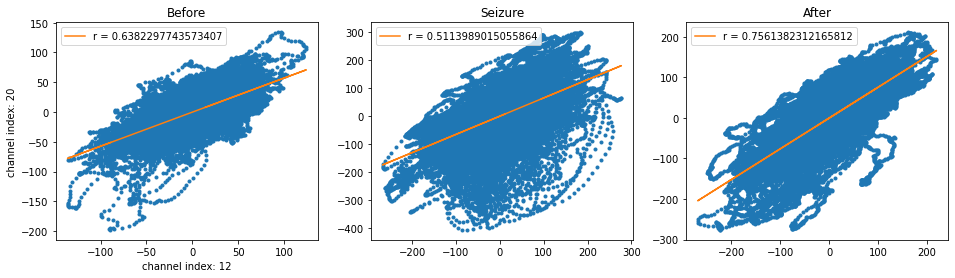

In [99]:
slope1, intercept1, r1,  p, stderr = stats.linregress(before[:,12],before[:,20])
slope2, intercept2, r2,  p, stderr = stats.linregress(seizure[:,12],seizure[:,20])
slope3, intercept3, r3,  p, stderr = stats.linregress(after[:,12],after[:,20])
figure(figsize=(16,4))
subplot(131)
plt.plot(before[:,12],before[:,20], '.')
plot(before[:,12], intercept1 + slope1 * before[:,12], label='r = '+ str(r1))
xlabel('channel index: 12')
ylabel('channel index: 20')
title('Before')
legend()
subplot(132)
plt.plot(seizure[:,12],seizure[:,20], '.')
plot(seizure[:,12], intercept2 + slope2 * seizure[:,12], label='r = '+str(r2))
title('Seizure')
legend()
subplot(133)
plt.plot(after[:,12],after[:,20], '.')
plot(after[:,12], intercept3 + slope3 * after[:,12], label='r = '+str(r3))
title('After')
legend()

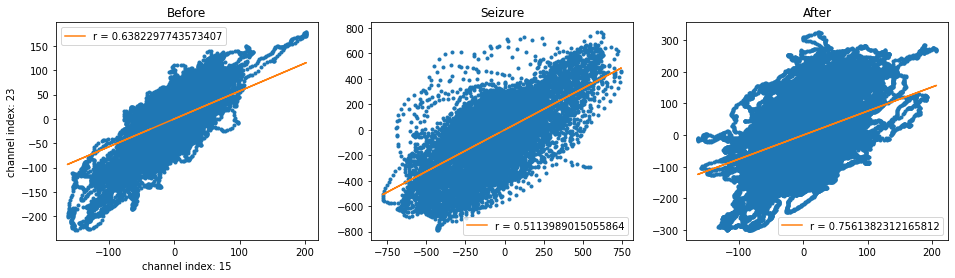

In [102]:
slope1, intercept1, r1,  p, stderr = stats.linregress(before[:,12],before[:,20])
slope2, intercept2, r2,  p, stderr = stats.linregress(seizure[:,12],seizure[:,20])
slope3, intercept3, r3,  p, stderr = stats.linregress(after[:,12],after[:,20])
figure(figsize=(16,4))
subplot(131)
plt.plot(before[:,15],before[:,23], '.')
plot(before[:,15], intercept1 + slope1 * before[:,15], label='r = '+ str(r1))
xlabel('channel index: 15')
ylabel('channel index: 23')
title('Before')
legend()
subplot(132)
plt.plot(seizure[:,15],seizure[:,23], '.')
plot(seizure[:,15], intercept2 + slope2 * seizure[:,15], label='r = '+str(r2))
title('Seizure')
legend()
subplot(133)
plt.plot(after[:,15],after[:,23], '.')
plot(after[:,15], intercept3 + slope3 * after[:,15], label='r = '+str(r3))
title('After')
legend()

The correlation between these channels is well observable in this kind of plot as well. The correlation coefficient (r value) is the highest after the seizure usullay, which is consistent with what we see on the coefficient matrix colormaps.

Also, these plots provide a more nuanced picture in some sense. For example in the case of channel 1 and 8 we can see that the r value is almost the same before and during the seizure, but the structure of the plot is quite different in the 'channel space'. This is something we can not possibly see on a coefficient matrix colormap.

For comparison I included a plot of a channels that do not correlate.

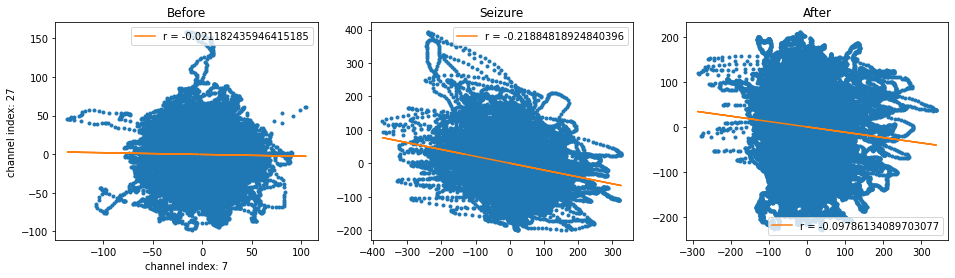

In [103]:
slope1, intercept1, r1,  p, stderr = stats.linregress(before[:,7],before[:,27])
slope2, intercept2, r2,  p, stderr = stats.linregress(seizure[:,7],seizure[:,27])
slope3, intercept3, r3,  p, stderr = stats.linregress(after[:,7],after[:,27])
figure(figsize=(16,4))
subplot(131)
plt.plot(before[:,7],before[:,27], '.')
plot(before[:,7], intercept1 + slope1 * before[:,7], label='r = '+ str(r1))
xlabel('channel index: 7')
ylabel('channel index: 27')
title('Before')
legend()
subplot(132)
plt.plot(seizure[:,7],seizure[:,27], '.')
plot(seizure[:,7], intercept2 + slope2 * seizure[:,7], label='r = '+str(r2))
title('Seizure')
legend()
subplot(133)
plt.plot(after[:,7],after[:,27], '.')
plot(after[:,7], intercept3 + slope3 * after[:,7], label='r = '+str(r3))
title('After')
legend()

Here I plot two channels (4 and 34) that were correlating the most during the seizure according to the colormap. 

It is worth noting that eventhough the r value is almost as high as in the case of channel 1 and 8, the latter is much more structural therefore the correlation between the latter two channels is more convincing.


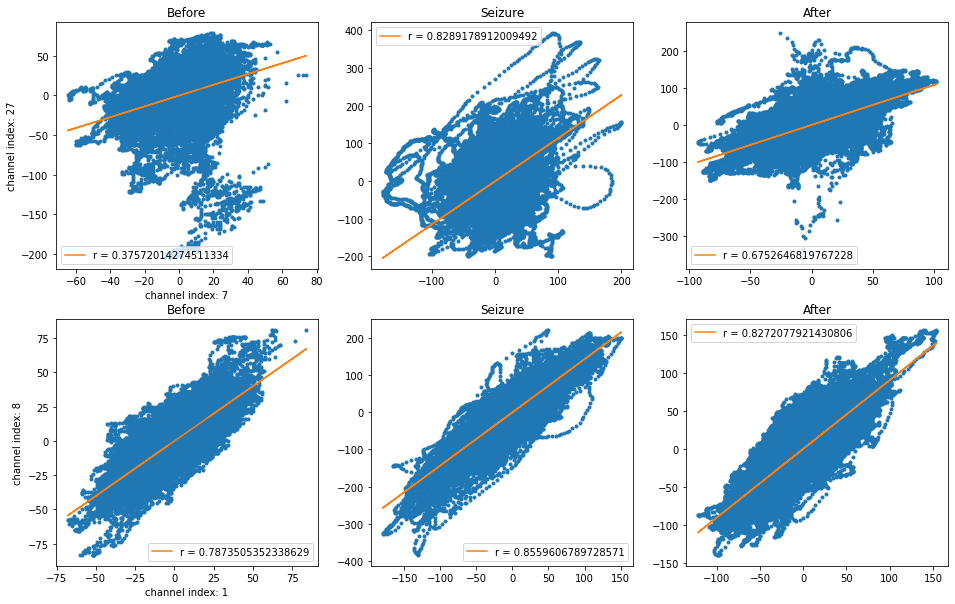

In [107]:
slope1, intercept1, r1,  p, stderr = stats.linregress(before[:,4],before[:,34])
slope2, intercept2, r2,  p, stderr = stats.linregress(seizure[:,4],seizure[:,34])
slope3, intercept3, r3,  p, stderr = stats.linregress(after[:,4],after[:,34])
figure(figsize=(16,10))
subplot(231)
plt.plot(before[:,4],before[:,34], '.')
plot(before[:,4], intercept1 + slope1 * before[:,4], label='r = '+ str(r1))
xlabel('channel index: 7')
ylabel('channel index: 27')
title('Before')
legend()
subplot(232)
plt.plot(seizure[:,4],seizure[:,27], '.')
plot(seizure[:,4], intercept2 + slope2 * seizure[:,4], label='r = '+str(r2))
title('Seizure')
legend()
subplot(233)
plt.plot(after[:,4],after[:,34], '.')
plot(after[:,4], intercept3 + slope3 * after[:,4], label='r = '+str(r3))
title('After')
legend()

slope4, intercept4, r4,  p, stderr = stats.linregress(before[:,1],before[:,8])
slope5, intercept5, r5,  p, stderr = stats.linregress(seizure[:,1],seizure[:,8])
slope6, intercept6, r6,  p, stderr = stats.linregress(after[:,1],after[:,8])

subplot(234)
plt.plot(before[:,1],before[:,8], '.')
plot(before[:,1], intercept4 + slope4 * before[:,1], label='r = '+ str(r4))
xlabel('channel index: 1')
ylabel('channel index: 8')
title('Before')
legend()
subplot(235)
plt.plot(seizure[:,1],seizure[:,8], '.')
plot(seizure[:,1], intercept5 + slope5 * seizure[:,1], label='r = '+str(r5))
title('Seizure')
legend()
subplot(236)
plt.plot(after[:,1],after[:,8], '.')
plot(after[:,1], intercept6 + slope6 * after[:,1], label='r = '+str(r6))
title('After')
legend()


Lastly, I plotted a few channel pairs from channels 30-40, since these channels were highly correlated during and after seizure, but not before it.

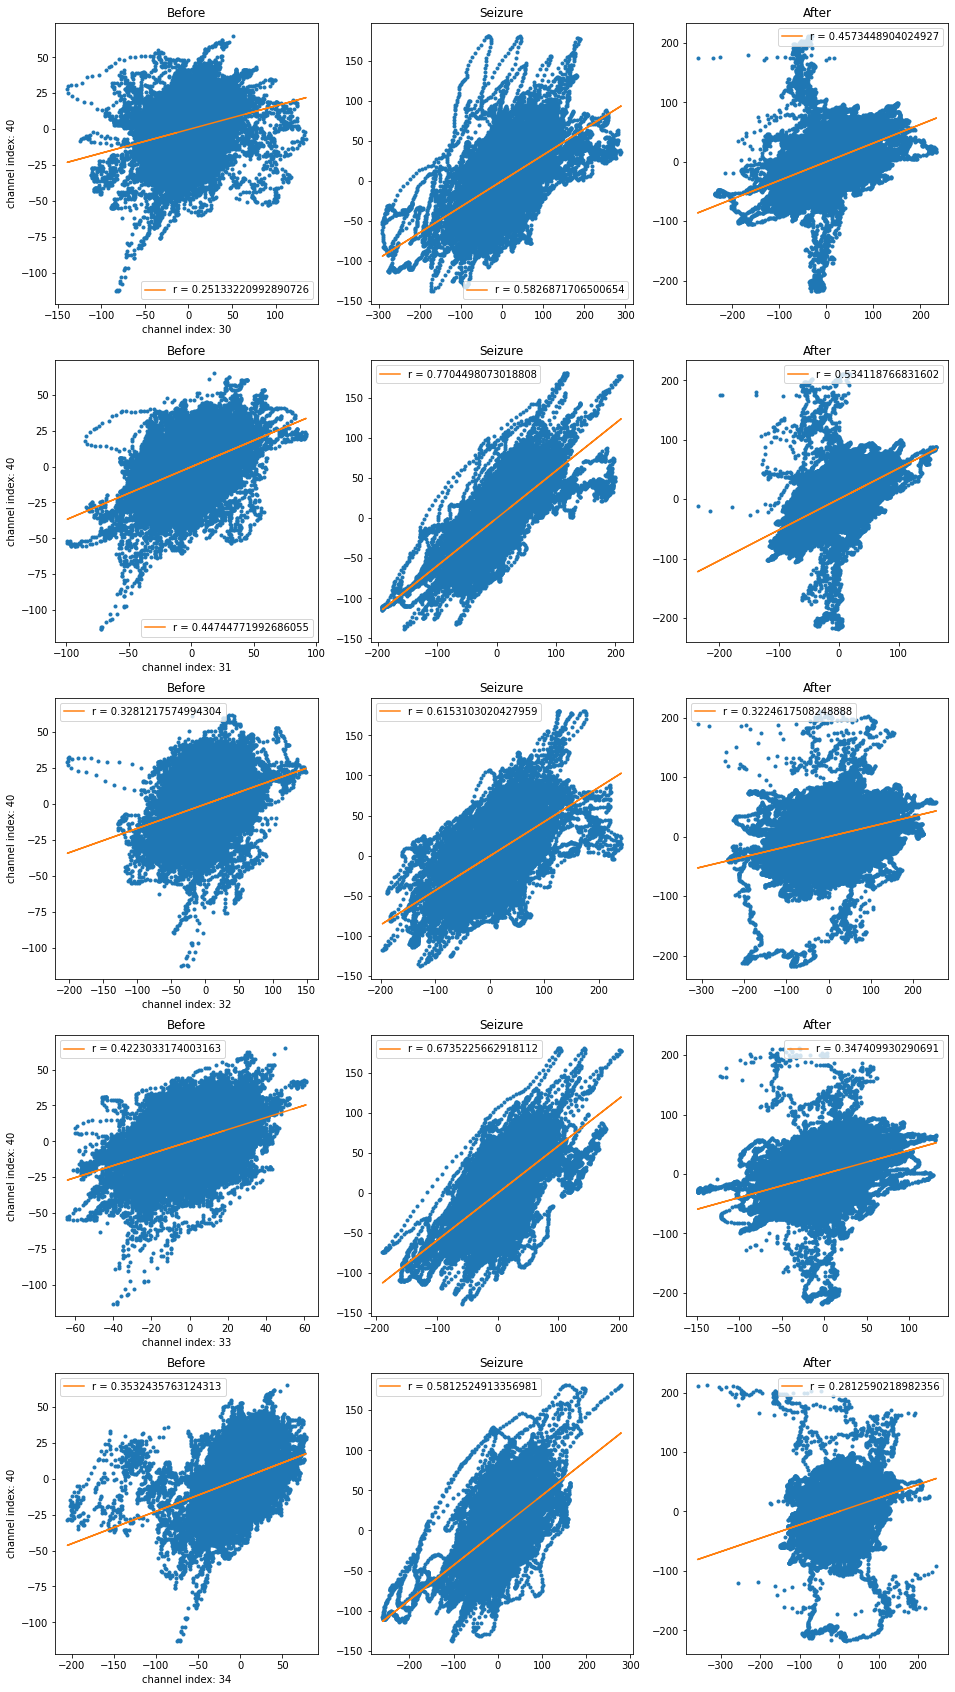

In [112]:
slope1, intercept1, r1,  p, stderr = stats.linregress(before[:,30],before[:,40])
slope2, intercept2, r2,  p, stderr = stats.linregress(seizure[:,30],seizure[:,40])
slope3, intercept3, r3,  p, stderr = stats.linregress(after[:,30],after[:,40])


figure(figsize=(16,30))
subplot(531)
plt.plot(before[:,30],before[:,40], '.')
plot(before[:,30], intercept1 + slope1 * before[:,30], label='r = '+ str(r1))
xlabel('channel index: 30')
ylabel('channel index: 40')
title('Before')
legend()
subplot(532)
plt.plot(seizure[:,30],seizure[:,40], '.')
plot(seizure[:,30], intercept2 + slope2 * seizure[:,30], label='r = '+str(r2))
title('Seizure')
legend()
subplot(533)
plt.plot(after[:,30],after[:,40], '.')
plot(after[:,30], intercept3 + slope3 * after[:,30], label='r = '+str(r3))
title('After')
legend()

slope4, intercept4, r4,  p, stderr = stats.linregress(before[:,31],before[:,40])
slope5, intercept5, r5,  p, stderr = stats.linregress(seizure[:,31],seizure[:,40])
slope6, intercept6, r6,  p, stderr = stats.linregress(after[:,31],after[:,40])

subplot(534)
plt.plot(before[:,31],before[:,40], '.')
plot(before[:,31], intercept4 + slope4 * before[:,31], label='r = '+ str(r4))
xlabel('channel index: 31')
ylabel('channel index: 40')
title('Before')
legend()
subplot(535)
plt.plot(seizure[:,31],seizure[:,40], '.')
plot(seizure[:,31], intercept5 + slope5 * seizure[:,31], label='r = '+str(r5))
title('Seizure')
legend()
subplot(536)
plt.plot(after[:,31],after[:,40], '.')
plot(after[:,31], intercept6 + slope6 * after[:,31], label='r = '+str(r6))
title('After')
legend()

slope7, intercept7, r7,  p, stderr = stats.linregress(before[:,32],before[:,40])
slope8, intercept8, r8,  p, stderr = stats.linregress(seizure[:,32],seizure[:,40])
slope9, intercept9, r9,  p, stderr = stats.linregress(after[:,32],after[:,40])

subplot(537)
plt.plot(before[:,32],before[:,40], '.')
plot(before[:,32], intercept7 + slope7 * before[:,32], label='r = '+ str(r7))
xlabel('channel index: 32')
ylabel('channel index: 40')
title('Before')
legend()
subplot(538)
plt.plot(seizure[:,32],seizure[:,40], '.')
plot(seizure[:,32], intercept8 + slope8 * seizure[:,32], label='r = '+str(r8))
title('Seizure')
legend()
subplot(539)
plt.plot(after[:,32],after[:,40], '.')
plot(after[:,32], intercept9 + slope9 * after[:,32], label='r = '+str(r9))
title('After')
legend()

slope10, intercept10, r10,  p, stderr = stats.linregress(before[:,33],before[:,40])
slope11, intercept11, r11,  p, stderr = stats.linregress(seizure[:,33],seizure[:,40])
slope12, intercept12, r12,  p, stderr = stats.linregress(after[:,33],after[:,40])

subplot(5,3,10)
plt.plot(before[:,33],before[:,40], '.')
plot(before[:,33], intercept10 + slope10 * before[:,33], label='r = '+ str(r10))
xlabel('channel index: 33')
ylabel('channel index: 40')
title('Before')
legend()
subplot(5,3,11)
plt.plot(seizure[:,33],seizure[:,40], '.')
plot(seizure[:,33], intercept11 + slope11 * seizure[:,33], label='r = '+str(r11))
title('Seizure')
legend()
subplot(5,3,12)
plt.plot(after[:,33],after[:,40], '.')
plot(after[:,33], intercept12 + slope12 * after[:,33], label='r = '+str(r12))
title('After')
legend()

slope13, intercept13, r13,  p, stderr = stats.linregress(before[:,34],before[:,40])
slope14, intercept14, r14,  p, stderr = stats.linregress(seizure[:,34],seizure[:,40])
slope15, intercept15, r15,  p, stderr = stats.linregress(after[:,34],after[:,40])

subplot(5,3,13)
plt.plot(before[:,34],before[:,40], '.')
plot(before[:,34], intercept13 + slope13 * before[:,34], label='r = '+ str(r13))
xlabel('channel index: 34')
ylabel('channel index: 40')
title('Before')
legend()
subplot(5,3,14)
plt.plot(seizure[:,34],seizure[:,40], '.')
plot(seizure[:,34], intercept14 + slope14 * seizure[:,34], label='r = '+str(r14))
title('Seizure')
legend()
subplot(5,3,15)
plt.plot(after[:,34],after[:,40], '.')
plot(after[:,34], intercept15 + slope15 * after[:,34], label='r = '+str(r15))
title('After')
legend()

I plotted channel 40 as a function of channel 30,31,32,33 and 34. In this area it seems like the correlation increased largely during the seizure, then it decreased after it although it was still somewhat larger than before the seizure.

# Disciussion

Overall the effect of seizure on the correlation of neural activity recorded on multiple channels is quite complex. 

Neural activity becomes more correlated during an epileptic seizure (to my surprise). Usually in the case of a lot of neurons or brain regions that were somewhat correlated to begin with become even more correlated during a seizure. In addition, areas that were not correlated can become correlated during seizure, then relax back into the their uncorrelated state after it. 

However, the 'channel space' plots showed that the underlying fireing pattern that produces high correlation coefficients can be very different, which complicates the situation. Therefore it is hard to see what exact effect a seizure has on the connection between different neurons or brain areas.